# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
# sort dfdata based on longitude
dfdata = dfdata.sort_values("longitude")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
5962,-180,38,4,-5425.0,NaN,5.702333,NaN,427.678925,34.342628,NaN,15.691460
5757,-180,39,4,-5335.0,NaN,5.829761,NaN,497.673096,34.254448,NaN,14.695810
32077,-180,-55,4,-5287.0,NaN,6.456027,NaN,335.052032,34.125984,NaN,6.751073
5562,-180,40,4,-5241.0,NaN,5.968406,NaN,584.339844,34.158997,NaN,13.663589


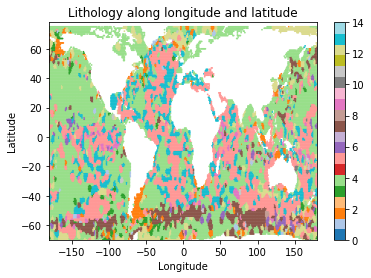

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = pl.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

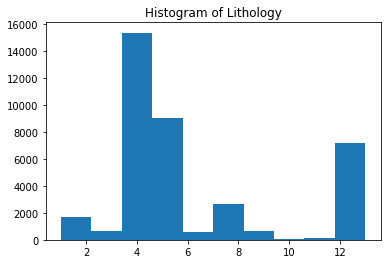

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    pl.hist(y)
    pl.title(title)
    pl.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using TensorFlow backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)

# don't drop out lon and lat
# features.remove("longitude")
# features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
initializer = "random_uniform"
dropout_ratio = 0.1
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction_layer = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction_layer)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total para

In [7]:
# shuffle samples
rnd = np.random.RandomState(seed)
shuffle_index = np.arange(N)
rnd.shuffle(shuffle_index)
X = X[shuffle_index]
Y = Y[shuffle_index]
dummy_Y = dummy_Y[shuffle_index]

Train on 24351 samples, validate on 6088 samples
Epoch 1/100
24351/24351 [==============================] - 6s 255us/step - loss: 1.4494 - acc: 0.5034 - val_loss: 1.3458 - val_acc: 0.5340
Epoch 2/100
24351/24351 [==============================] - 6s 255us/step - loss: 1.3602 - acc: 0.5298 - val_loss: 1.3285 - val_acc: 0.5319
Epoch 3/100
24351/24351 [==============================] - 6s 250us/step - loss: 1.3249 - acc: 0.5407 - val_loss: 1.2814 - val_acc: 0.5636
Epoch 4/100
24351/24351 [==============================] - 6s 245us/step - loss: 1.3005 - acc: 0.5463 - val_loss: 1.2786 - val_acc: 0.5598
Epoch 5/100
24351/24351 [==============================] - 6s 246us/step - loss: 1.2827 - acc: 0.5506 - val_loss: 1.2623 - val_acc: 0.5457
Epoch 6/100
24351/24351 [==============================] - 6s 250us/step - loss: 1.2677 - acc: 0.5541 - val_loss: 1.2357 - val_acc: 0.5673
Epoch 7/100
24351/24351 [==============================] - 6s 245us/step - loss: 1.2514 - acc: 0.5601 - val_loss: 1.2

24351/24351 [==============================] - 6s 246us/step - loss: 1.0708 - acc: 0.6091 - val_loss: 1.0612 - val_acc: 0.6101
Epoch 60/100
24351/24351 [==============================] - 6s 252us/step - loss: 1.0711 - acc: 0.6091 - val_loss: 1.0510 - val_acc: 0.6199
Epoch 61/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0731 - acc: 0.6088 - val_loss: 1.0503 - val_acc: 0.6114
Epoch 62/100
24351/24351 [==============================] - 6s 248us/step - loss: 1.0643 - acc: 0.6161 - val_loss: 1.0582 - val_acc: 0.6227
Epoch 63/100
24351/24351 [==============================] - 6s 248us/step - loss: 1.0656 - acc: 0.6153 - val_loss: 1.0621 - val_acc: 0.6110
Epoch 64/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0621 - acc: 0.6125 - val_loss: 1.0433 - val_acc: 0.6189
Epoch 65/100
24351/24351 [==============================] - 6s 250us/step - loss: 1.0611 - acc: 0.6125 - val_loss: 1.0430 - val_acc: 0.6235
Epoch 66/100
24351/24351 [=======

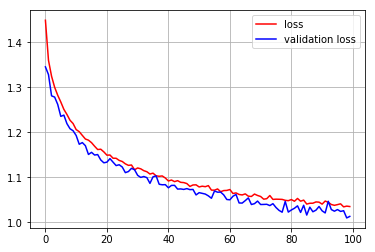

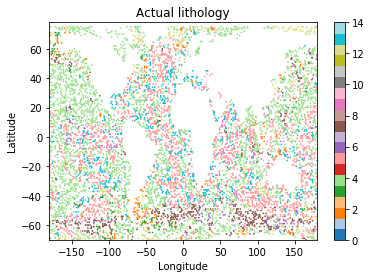

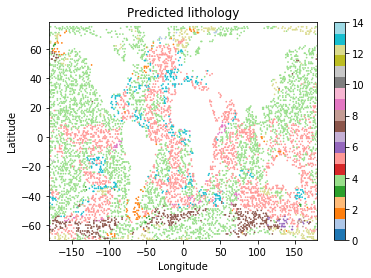

Train on 24351 samples, validate on 6088 samples
Epoch 1/100
24351/24351 [==============================] - 6s 242us/step - loss: 1.0467 - acc: 0.6222 - val_loss: 1.0336 - val_acc: 0.6253
Epoch 2/100
24351/24351 [==============================] - 5s 211us/step - loss: 1.0384 - acc: 0.6222 - val_loss: 1.0278 - val_acc: 0.6289
Epoch 3/100
24351/24351 [==============================] - 5s 208us/step - loss: 1.0410 - acc: 0.6202 - val_loss: 1.0122 - val_acc: 0.6314
Epoch 4/100
24351/24351 [==============================] - 5s 205us/step - loss: 1.0407 - acc: 0.6235 - val_loss: 1.0132 - val_acc: 0.6304
Epoch 5/100
24351/24351 [==============================] - 5s 205us/step - loss: 1.0390 - acc: 0.6228 - val_loss: 1.0125 - val_acc: 0.6375
Epoch 6/100
24351/24351 [==============================] - 5s 205us/step - loss: 1.0394 - acc: 0.6219 - val_loss: 1.0263 - val_acc: 0.6261
Epoch 7/100
24351/24351 [==============================] - 5s 203us/step - loss: 1.0347 - acc: 0.6238 - val_loss: 1.0

24351/24351 [==============================] - 6s 248us/step - loss: 1.0133 - acc: 0.6304 - val_loss: 1.0208 - val_acc: 0.6368
Epoch 60/100
24351/24351 [==============================] - 6s 255us/step - loss: 1.0115 - acc: 0.6324 - val_loss: 0.9946 - val_acc: 0.6416
Epoch 61/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0089 - acc: 0.6318 - val_loss: 1.0021 - val_acc: 0.6385
Epoch 62/100
24351/24351 [==============================] - 6s 253us/step - loss: 1.0052 - acc: 0.6322 - val_loss: 0.9986 - val_acc: 0.6370
Epoch 63/100
24351/24351 [==============================] - 6s 231us/step - loss: 1.0010 - acc: 0.6315 - val_loss: 0.9900 - val_acc: 0.6375
Epoch 64/100
24351/24351 [==============================] - 6s 252us/step - loss: 1.0104 - acc: 0.6310 - val_loss: 0.9908 - val_acc: 0.6404
Epoch 65/100
24351/24351 [==============================] - 5s 214us/step - loss: 1.0016 - acc: 0.6356 - val_loss: 0.9882 - val_acc: 0.6429
Epoch 66/100
24351/24351 [=======

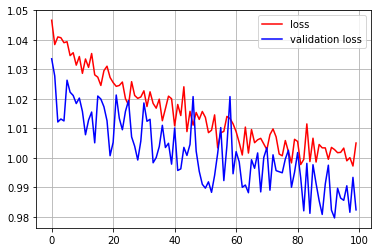

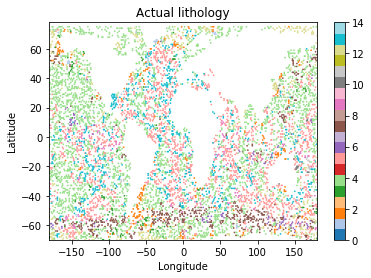

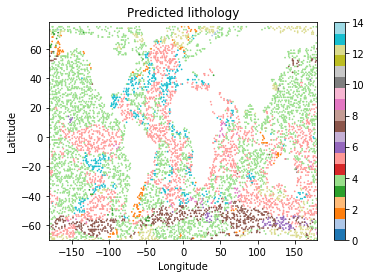

Train on 24351 samples, validate on 6088 samples
Epoch 1/100
24351/24351 [==============================] - 5s 214us/step - loss: 1.0303 - acc: 0.6274 - val_loss: 0.9900 - val_acc: 0.6365
Epoch 2/100
24351/24351 [==============================] - 5s 211us/step - loss: 1.0232 - acc: 0.6289 - val_loss: 0.9926 - val_acc: 0.6368
Epoch 3/100
24351/24351 [==============================] - 5s 205us/step - loss: 1.0180 - acc: 0.6277 - val_loss: 0.9919 - val_acc: 0.6311
Epoch 4/100
24351/24351 [==============================] - 5s 207us/step - loss: 1.0150 - acc: 0.6320 - val_loss: 0.9807 - val_acc: 0.6396
Epoch 5/100
24351/24351 [==============================] - 5s 206us/step - loss: 1.0226 - acc: 0.6288 - val_loss: 0.9862 - val_acc: 0.6344
Epoch 6/100
24351/24351 [==============================] - 5s 211us/step - loss: 1.0162 - acc: 0.6305 - val_loss: 0.9908 - val_acc: 0.6386
Epoch 7/100
24351/24351 [==============================] - 5s 213us/step - loss: 1.0246 - acc: 0.6288 - val_loss: 0.9

24351/24351 [==============================] - 5s 204us/step - loss: 1.0082 - acc: 0.6302 - val_loss: 0.9857 - val_acc: 0.6434
Epoch 60/100
24351/24351 [==============================] - 5s 205us/step - loss: 1.0040 - acc: 0.6346 - val_loss: 0.9789 - val_acc: 0.6370
Epoch 61/100
24351/24351 [==============================] - 5s 212us/step - loss: 1.0014 - acc: 0.6353 - val_loss: 0.9900 - val_acc: 0.6386
Epoch 62/100
24351/24351 [==============================] - 5s 207us/step - loss: 1.0019 - acc: 0.6348 - val_loss: 0.9854 - val_acc: 0.6335
Epoch 63/100
24351/24351 [==============================] - 5s 206us/step - loss: 1.0041 - acc: 0.6334 - val_loss: 0.9818 - val_acc: 0.6447
Epoch 64/100
24351/24351 [==============================] - 5s 207us/step - loss: 0.9984 - acc: 0.6377 - val_loss: 0.9699 - val_acc: 0.6465
Epoch 65/100
24351/24351 [==============================] - 5s 208us/step - loss: 0.9949 - acc: 0.6355 - val_loss: 0.9787 - val_acc: 0.6408
Epoch 66/100
24351/24351 [=======

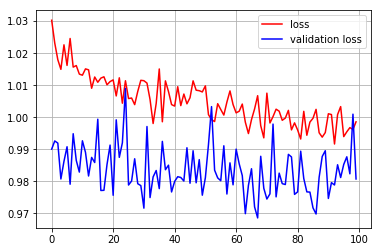

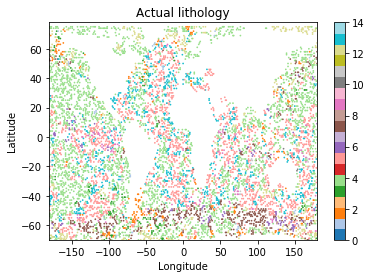

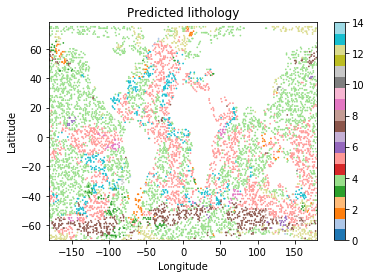

Train on 24351 samples, validate on 6088 samples
Epoch 1/100
24351/24351 [==============================] - 5s 210us/step - loss: 1.0233 - acc: 0.6270 - val_loss: 0.9723 - val_acc: 0.6422
Epoch 2/100
24351/24351 [==============================] - 5s 201us/step - loss: 1.0146 - acc: 0.6350 - val_loss: 0.9959 - val_acc: 0.6376
Epoch 3/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0136 - acc: 0.6325 - val_loss: 0.9809 - val_acc: 0.6376
Epoch 4/100
24351/24351 [==============================] - 6s 249us/step - loss: 1.0141 - acc: 0.6336 - val_loss: 0.9855 - val_acc: 0.6388
Epoch 5/100
24351/24351 [==============================] - 6s 252us/step - loss: 1.0086 - acc: 0.6324 - val_loss: 0.9666 - val_acc: 0.6450
Epoch 6/100
24351/24351 [==============================] - 6s 253us/step - loss: 1.0028 - acc: 0.6332 - val_loss: 0.9866 - val_acc: 0.6408
Epoch 7/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0062 - acc: 0.6343 - val_loss: 0.9

24351/24351 [==============================] - 6s 233us/step - loss: 0.9965 - acc: 0.6404 - val_loss: 0.9644 - val_acc: 0.6449
Epoch 60/100
24351/24351 [==============================] - 6s 251us/step - loss: 0.9918 - acc: 0.6367 - val_loss: 0.9784 - val_acc: 0.6414
Epoch 61/100
24351/24351 [==============================] - 6s 235us/step - loss: 0.9917 - acc: 0.6392 - val_loss: 0.9818 - val_acc: 0.6404
Epoch 62/100
24351/24351 [==============================] - 6s 237us/step - loss: 0.9949 - acc: 0.6364 - val_loss: 0.9737 - val_acc: 0.6444
Epoch 63/100
24351/24351 [==============================] - 6s 250us/step - loss: 0.9893 - acc: 0.6389 - val_loss: 0.9739 - val_acc: 0.6437
Epoch 64/100
24351/24351 [==============================] - 6s 253us/step - loss: 0.9952 - acc: 0.6365 - val_loss: 0.9818 - val_acc: 0.6381
Epoch 65/100
24351/24351 [==============================] - 6s 252us/step - loss: 0.9924 - acc: 0.6395 - val_loss: 0.9742 - val_acc: 0.6424
Epoch 66/100
24351/24351 [=======

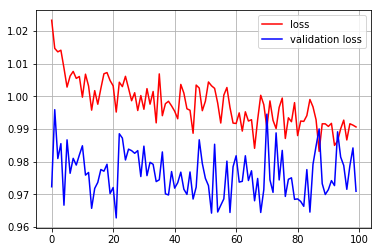

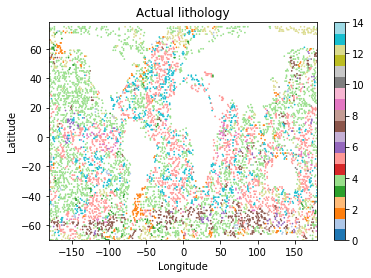

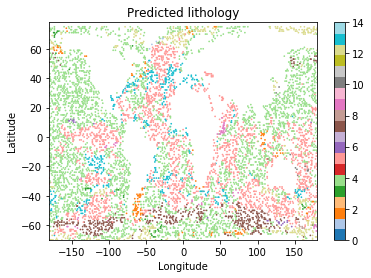

Train on 24352 samples, validate on 6088 samples
Epoch 1/100
24352/24352 [==============================] - 5s 211us/step - loss: 0.9994 - acc: 0.6390 - val_loss: 0.9326 - val_acc: 0.6625
Epoch 2/100
24352/24352 [==============================] - 6s 250us/step - loss: 0.9950 - acc: 0.6393 - val_loss: 0.9307 - val_acc: 0.6677
Epoch 3/100
24352/24352 [==============================] - 6s 240us/step - loss: 0.9973 - acc: 0.6372 - val_loss: 0.9329 - val_acc: 0.6613
Epoch 4/100
24352/24352 [==============================] - 5s 218us/step - loss: 0.9997 - acc: 0.6376 - val_loss: 0.9400 - val_acc: 0.6587
Epoch 5/100
24352/24352 [==============================] - 6s 236us/step - loss: 0.9893 - acc: 0.6407 - val_loss: 0.9320 - val_acc: 0.6574
Epoch 6/100
24352/24352 [==============================] - 6s 232us/step - loss: 0.9953 - acc: 0.6395 - val_loss: 0.9298 - val_acc: 0.6554
Epoch 7/100
24352/24352 [==============================] - 6s 253us/step - loss: 1.0020 - acc: 0.6397 - val_loss: 0.9

24352/24352 [==============================] - 6s 253us/step - loss: 0.9904 - acc: 0.6409 - val_loss: 0.9347 - val_acc: 0.6508
Epoch 60/100
24352/24352 [==============================] - 6s 254us/step - loss: 0.9932 - acc: 0.6375 - val_loss: 0.9406 - val_acc: 0.6569
Epoch 61/100
24352/24352 [==============================] - 6s 249us/step - loss: 0.9895 - acc: 0.6400 - val_loss: 0.9425 - val_acc: 0.6583
Epoch 62/100
24352/24352 [==============================] - 6s 247us/step - loss: 0.9978 - acc: 0.6392 - val_loss: 0.9462 - val_acc: 0.6567
Epoch 63/100
24352/24352 [==============================] - 6s 249us/step - loss: 0.9882 - acc: 0.6380 - val_loss: 0.9376 - val_acc: 0.6592
Epoch 64/100
24352/24352 [==============================] - 6s 248us/step - loss: 0.9910 - acc: 0.6387 - val_loss: 0.9451 - val_acc: 0.6556
Epoch 65/100
24352/24352 [==============================] - 6s 248us/step - loss: 0.9883 - acc: 0.6403 - val_loss: 0.9343 - val_acc: 0.6626
Epoch 66/100
24352/24352 [=======

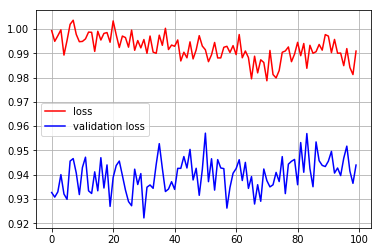

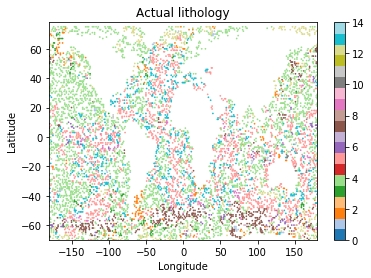

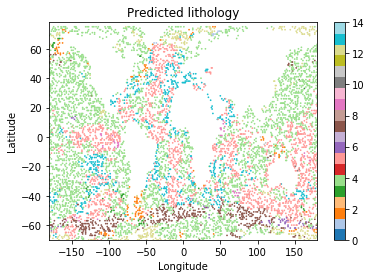

In [8]:
# parameters for training
epochs = 100
batch_size = 5
verbose = True

# use 5 fold cross validation without shuffle
kfold = KFold(n_splits=5, random_state=seed)
lon = dfdata["longitude"].values[shuffle_index]
lat = dfdata["latitude"].values[shuffle_index]

def calculate_entropy(row):
    return -np.sum(row * np.log(row + 1e-10))


# training
prediction = np.zeros((N, numclass))
entropy = np.zeros(N)
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    # record loss in training and validation
    history = History()
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight,
              validation_split=0.2, shuffle=True, callbacks=[history])
    # plot loss versus epochs
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    pl.plot(history.epoch, loss, "r-", label="loss")
    pl.plot(history.epoch, val_loss, "b-", label="validation loss")
    pl.grid()
    pl.legend()
    pl.show()
    # predict and draw scatterplot for prediction set
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu
    entropy[test_ind] = np.apply_along_axis(calculate_entropy, 1, mu)
    mean = np.argmax(mu, axis=1)
    draw_global(lon[test_ind], lat[test_ind], Y[test_ind] + 1, "Actual lithology")
    draw_global(lon[test_ind], lat[test_ind], mean + 1, "Predicted lithology")

In [13]:
np.apply_along_axis(calculate_entropy, 1, mu)

array([1.07974   , 1.439403  , 0.93029475, ..., 1.4441582 , 0.99522597,
       0.00599334], dtype=float32)

In [14]:
entropy[np.isnan(entropy)] = 0

### Validate

Accuracy = 0.6478488265131803


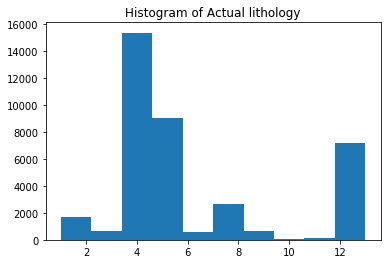

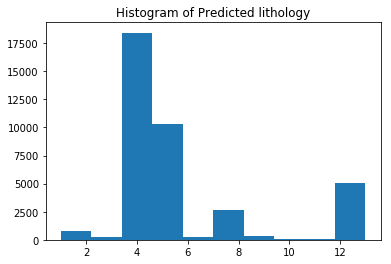

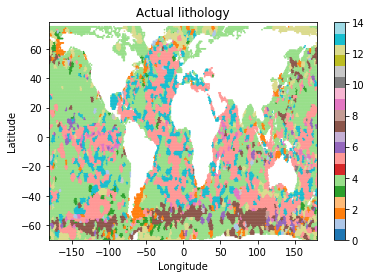

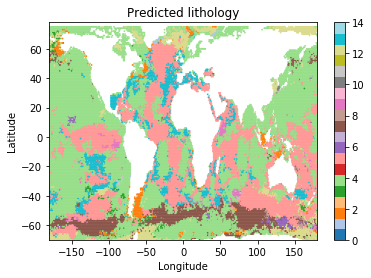

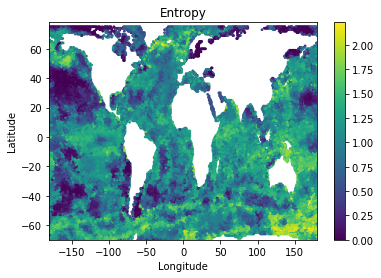

In [15]:
lon = dfdata["longitude"].values[shuffle_index]
lat = dfdata["latitude"].values[shuffle_index]

def draw_prob(lon, lat, p, title, size=3):
    sc = pl.scatter(lon, lat, s=size, c=p)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
    pl.close()
    

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")
draw_prob(lon, lat, entropy, "Entropy")

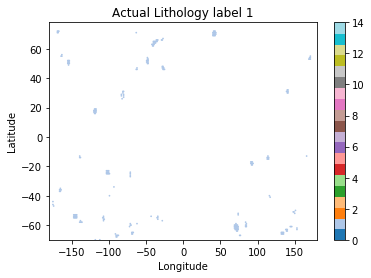

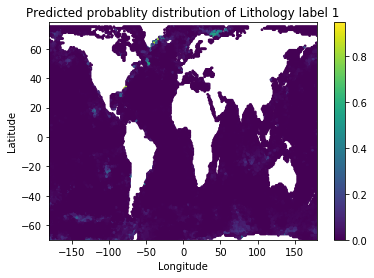

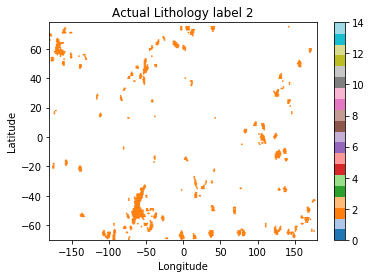

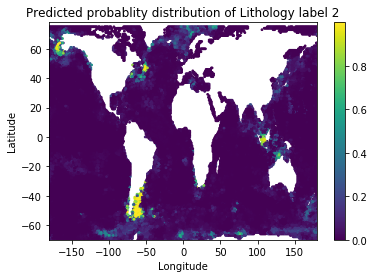

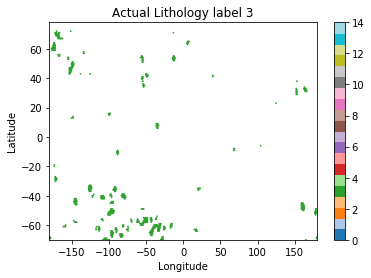

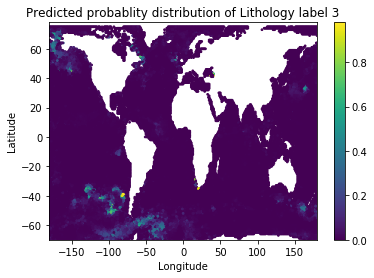

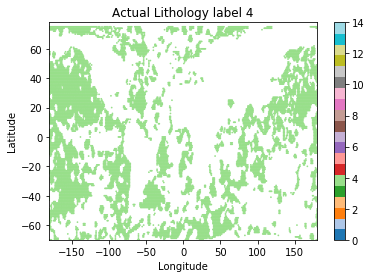

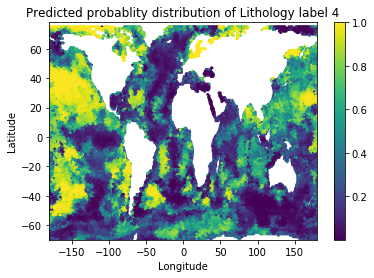

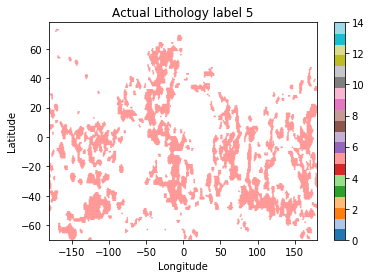

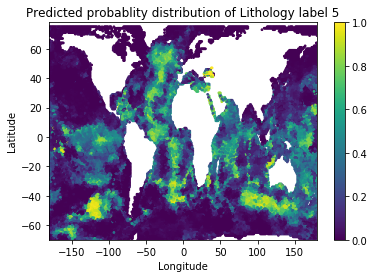

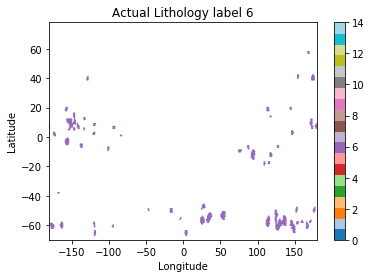

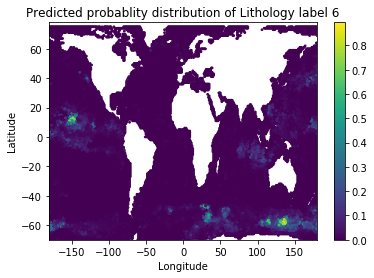

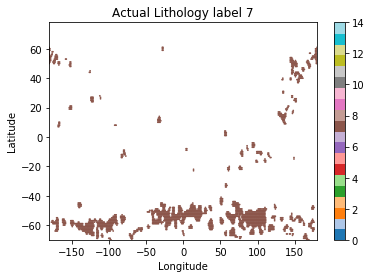

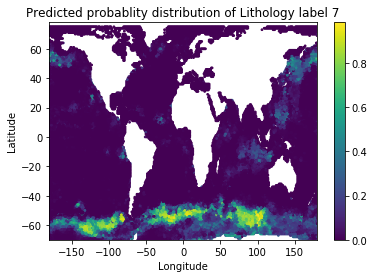

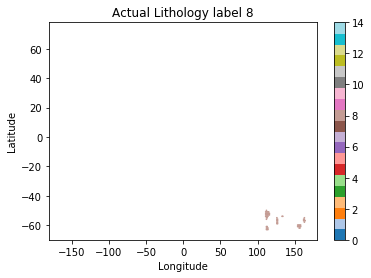

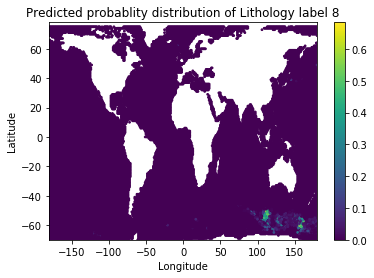

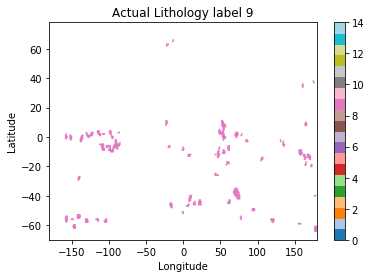

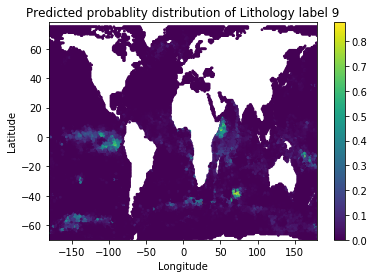

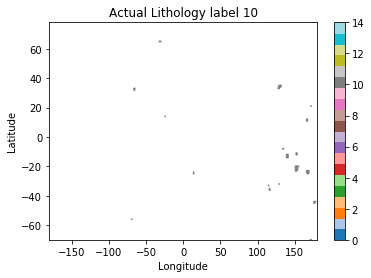

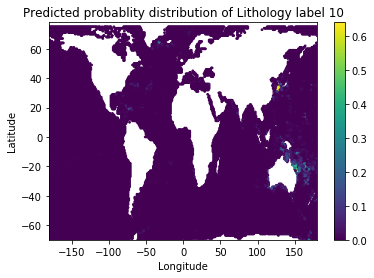

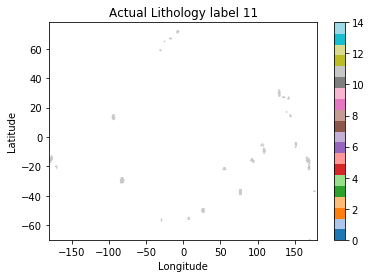

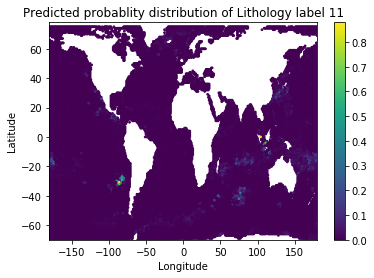

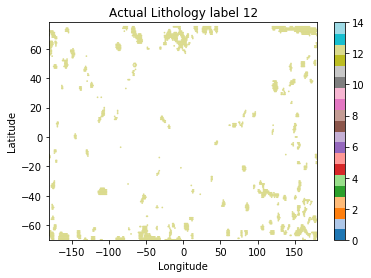

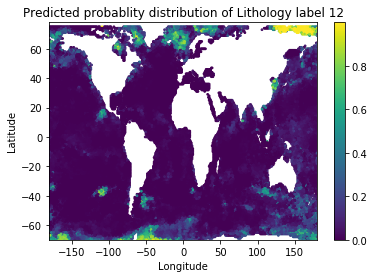

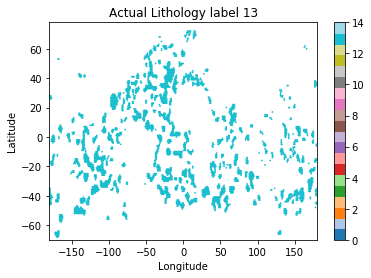

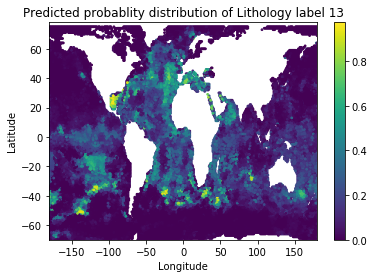

In [12]:
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)